## Kalman Filter Simulation

The following is a simulation of the Kalman Filter. This will later be used to compare
performance against Complementary Filter.

### Nav Sensor Dummy Simulation

In [3]:
from numpy.random import randn

class NavSensor(object):
    '''
    Parameters: 
        angle - angles calculated using accelerometer data
        angle_rate - gyro data
        noise_std - sensor estimated standard deviation
    '''
    def __init__(self, angle=(0, 0, 0), angle_rate=(0, 0 ,0), noise_std=1.):
        self.angle_rate = angle_rate
        self.noise_std = noise_std
        self.angle = [angle[0], angle[1], angle[2]]
        
    def read(self):
        self.angle[0] += self.angle_rate[0]
        self.angle[1] += self.angle_rate[1]
        self.angle[2] += self.angle_rate[2]
        
        return [self.angle[0] + randn() * self.noise_std,
                self.angle[1] + randn() * self.noise_std,
                self.angle[2] + randn() * self.noise_std]
        

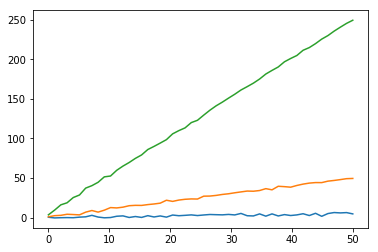

In [6]:
import matplotlib.pyplot as plt
import numpy as np

gyroXRate = .1
gyroYRate = 1
gyroZRate = 5
angle, angle_rate = (0, 0, 0), (gyroXRate, gyroYRate, gyroZRate)
sensor = NavSensor(angle, angle_rate, noise_std=1)
ns = np.array([sensor.read() for _ in range(50)])
x_line = np.linspace(0,50)
plt.plot(x_line,ns[:, 0])
plt.plot(x_line,ns[:, 1])
plt.plot(x_line,ns[:, 2])

### Kalman Filter

In [1]:
DT = 0.1
class KalmanFilter(object):
    def __init__(self):
        self.Q_angle = 0.01
        self.Q_gyro = 0.0003
        self.R_angle = 0.01
        self.x_bias = 0
        self.y_bias = 0
        self.XP_00 = 0
        self.XP_01 = 0
        self.XP_10 = 0
        self.XP_11 = 0
        
        self.YP_00 = 0
        self.YP_01 = 0
        self.YP_10 = 0
        self.YP_11 = 0
        
        self.KFangle = 0.0
        
    def update(self,accAngle=0.0, gyroRate = 0.0):
        self.KFangle = self.KFangle + DT *(gyroRate - self.y_bias)
        
        self.YP_00 = self.YP_00 + (-DT)*(self.YP_10 + self.YP_01) + self.Q_angle*DT
        self.YP_01 = self.YP_01 + (-DT)*self.YP_11
        self.YP_10 = self.YP_10 + (-DT)*self.YP_11
        self.YP_11 = self.YP_11 + self.Q_gyro*DT
        
        y = accAngle - self.KFangle
        S = self.YP_00 + self.R_angle
        K_0 = self.YP_00 / S
        K_1 = self.YP_10 / S
        
        self.KFangle = self.KFangle + K_0*y
        self.y_bias = self.y_bias + K_1*y
        
        self.YP_00 = self.YP_00 - K_0*self.YP_00
        self.YP_01 = self.YP_01 - K_0*self.YP_01
        self.YP_10 = self.YP_10 - K_1*self.YP_00
        self.YP_11 = self.YP_11 - K_1*self.YP_01
        
        return self.KFangle
        
        

### Testing Kalman Filter

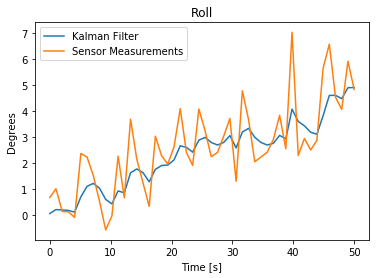

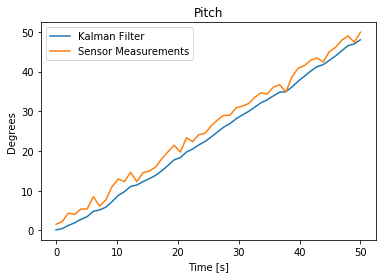

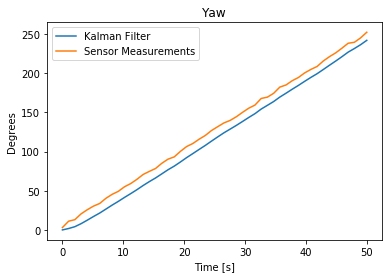

In [69]:
kalmanXAngle = KalmanFilter()
kalmanYAngle = KalmanFilter()
kalmanZAngle = KalmanFilter()
#gyroRate is set to 0 since gyroRate already specified when creating
#NavSensor object in above code
phi_Kdata = np.array([kalmanXAngle.update(phi,0) for phi in ns[:,0]])
theta_Kdata = np.array([kalmanYAngle.update(theta,0) for theta in ns[:,1]])
psi_Kdata = np.array([kalmanZAngle.update(psi,0) for psi in ns[:,2]])
#print(len(phi_data))
#print(phi_data)

# plot Roll Angle
plt.figure()
plt.plot(x_line,phi_Kdata,label='Kalman Filter')
plt.plot(x_line,ns[:, 0], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Roll')
plt.legend(loc=2)

# plot Pitch Angle
plt.figure()
plt.plot(x_line,theta_Kdata,label='Kalman Filter')
plt.plot(x_line,ns[:, 1], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Pitch')
plt.legend(loc=2)

# plot Yaw Angle
plt.figure()
plt.plot(x_line,psi_Kdata,label='Kalman Filter')
plt.plot(x_line,ns[:, 2], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Yaw')
plt.legend(loc=2)

## Complementary Filter Simulation

The following is a simulation of the Complementary Filter, this will be used to compare performance against Kalman Filter simulation.

### Complementary Filter

In [70]:
class ComplementaryFilter(object):
    def __init__(self, currAngle = 0):
        self.currAngle = currAngle

    def update(self, accAngle, gyroRate):
        AA = 0.98
        CAngle = AA*(self.currAngle + gyroRate*DT) + (1-AA)*accAngle
        self.currAngle = CAngle
        
        return self.currAngle

### Testing Complementary Filter

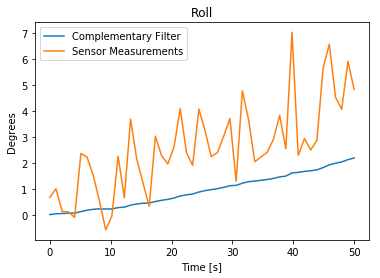

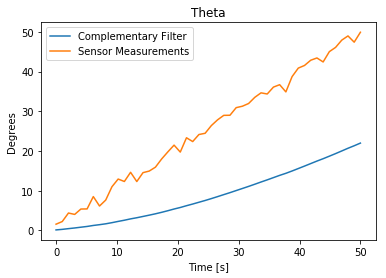

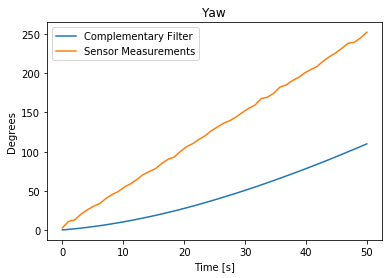

In [71]:
compXAngle = ComplementaryFilter()
compYAngle = ComplementaryFilter()
compZAngle = ComplementaryFilter()
# gyroRate is set to 0 since gyroRate already specified when creating
# NavSensor object in above code
phi_Cdata = np.array([compXAngle.update(phi,gyroXRate) for phi in ns[:,0]])
theta_Cdata = np.array([compYAngle.update(theta,gyroYRate) for theta in ns[:,1]])
psi_Cdata = np.array([compZAngle.update(psi,gyroZRate) for psi in ns[:,2]])

# plot Roll angle
plt.figure()
plt.plot(x_line,phi_Cdata,label='Complementary Filter')
plt.plot(x_line,ns[:, 0], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Roll')
plt.legend(loc=2)

# plot Pitch angle
plt.figure()
plt.plot(x_line,theta_Cdata,label='Complementary Filter')
plt.plot(x_line,ns[:, 1], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Theta')
plt.legend(loc=2)

# plot Yaw angle
plt.figure()
plt.plot(x_line,psi_Cdata,label='Complementary Filter')
plt.plot(x_line,ns[:, 2], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Yaw')
plt.legend(loc=2)

### Filter comparison plots

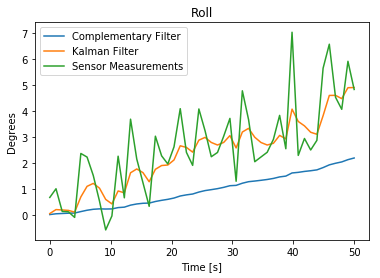

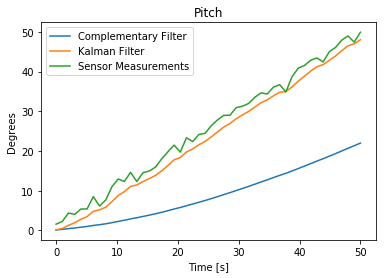

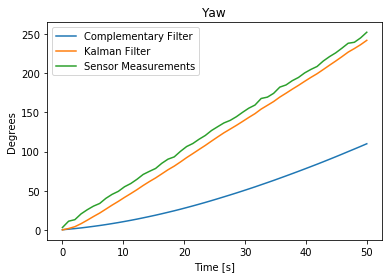

In [72]:
# plot Roll angle, roll is phi
plt.figure()
plt.plot(x_line,phi_Cdata,label='Complementary Filter')
plt.plot(x_line,phi_Kdata, label='Kalman Filter')
plt.plot(x_line,ns[:, 0], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Roll')
plt.legend(loc=2)

# plot Pitch angle, pitch is theta
plt.figure()
plt.plot(x_line,theta_Cdata,label='Complementary Filter')
plt.plot(x_line,theta_Kdata, label='Kalman Filter')
plt.plot(x_line,ns[:, 1], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Pitch')
plt.legend(loc=2)

# plot Yaw angle, yaw is psi
plt.figure()
plt.plot(x_line,psi_Cdata,label='Complementary Filter')
plt.plot(x_line,psi_Kdata, label='Kalman Filter')
plt.plot(x_line,ns[:, 2], label='Sensor Measurements')
plt.ylabel('Degrees')
plt.xlabel('Time [s]')
plt.title('Yaw')
plt.legend(loc=2)

Above plots show that under different gyroRates the Kalman Filter works best and Complementary Filter over time would drift too much from actual angle position, which could lead to unstable flight